In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{ "size":16}) #**{,,'serif':['Palatino']
rc('text', usetex=True)
import numpy.random as rnd
rnd.seed()
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
from scipy.optimize import brentq as solve
from scipy.integrate import odeint as ode
from scipy.special import gamma
np.set_printoptions(precision = 3, suppress = 1)
from matplotlib import cm
color = cm.get_cmap("Blues")

# Free field in 1D with long range interaction

We would like to construct a lattice regularization of the fractional Gaussian free field in 1D. That is defined by the Hamiltonian 
#### $$ H \propto \frac12 \int \frac{|\phi(x) - \phi(y)|^2}{|x-y|^{\alpha + 1}} \mathrm{d} x \mathrm{d} y     $$
In the continuum. Here $\alpha > 0$ will control the scaling properties of the field. It somehow allows to change "dimension" while staying at 1D. 

For technical reasons (related to Fourier transform), it is more convenient to consider a complex-valued field
#### $$ \phi = \varphi + \mathrm{i}\psi$$
Note that the action simply decouples into the real and imaginary parts, so we get two indepedent real fields. 

-------------------------------
Putting a field theory on the computer always requires a UV cutoff and an IR cutoff. In simple problems (without an intermediate scale), there are two conventions/point of views:
- The "continuum"/field theory/IR point of view, where the IR cutoff is O(1), and the UV cutoff is $1/M$.
- The "infinite lattice"/stat-mech/UV point of view, where the UV cutoff is O(1), and the IR cutoff is $M$.
Here we are taking a continuum point of view. 
---------------------------------



## Lattice regularization: continuum (IR) point of view
Let us put it on a periodic lattice of with $M$ sites. Then the lattice Hamiltonian reads 
#### $$ H = \frac12 \sum_{i<j} \frac{|\phi_i - \phi_j|^2}{r_{i-j}^{\alpha + 1}} \,,\,
r_{ij} = \sin(\pi \frac{|i-j|}M) $$
Note that $r_{ij}$ is (proportional) the arc length between $i$ and $j$ if the lattice points are placed uniformly on a circle. It captures the power law behavior of the continuum Hamiltonian as $|i-j| \ll M$. 

- By introducing the Fourier modes 
#### $$ \phi_j = \sum_{k=1}^M e^{\mathbf{i} 2 \pi k j / M } \hat{\phi}_k \,,\, 
 \hat\phi_k = \frac1L \sum_{j=1}^M e^{-\mathbf{i} 2 \pi k j / M } {\phi}_j $$
write $H$ in a diagonal form
#### $$ H = \frac12 \sum_{k=1}^M |\hat{\phi}_k|^2 G_k^{-1} \,. $$
Show that $G_k^{-1}$ is the Fourier transform of ....

- Conclude that $\hat{\phi}_k$ are independent complex random variables, whose real and imaginary parts are independent centred Gaussian with variance $G_k$. 


### The behavior of $G_k$

Below we calculate numerically $G_k$ by Fourier transform. Observe the behavior of $G_k$. Can you understand the power law? 

*(Optional)* Can we attempt to predict the prefactor from the continuum? For this we might need the formula (in 1d, see exercise sheet)
#### $$  \int |x|^{-2a}  e^{\mathbf{i} x k} \mathrm{d} x =  C(a) |k|^{2a-1} + A_0 + A_2 k^2 + \dots \,,\,  
   C(a) = \frac{\pi^{\frac{1}2} 2^{1-2 a} \Gamma \left(\frac12 -a\right)}{\Gamma (a)} \,, $$
 where $A_0, A_2$ are UV dependent constants (these terms appear only when the dominate $k^{2a-1}$ at small $k$.
 *(All questions below about prefactors are optional)*

In [ ]:
M = 2 ** 15
alpha = 1.5
rs = np.sin(np.arange(M) / M * np.pi)
rs[0]=1 # just to avoid a warning message
rhos = -1./rs ** (1 + alpha)  # 1/r^(alpha+1)
rhos[0]= -np.sum(rhos[1:])  # why? do you understand
Gkinverse = np.fft.ifft(rhos)

In [ ]:
xs = np.arange(1,M) / M
plt.loglog(xs, abs(rhos[1:]))
plt.xlabel(r"$(j-i)/M$")
plt.ylabel(r"$|r_{ij}|^{-\alpha-1}$")

In [ ]:
qs = np.arange(1,M)
plt.loglog(qs, abs(Gkinverse[1:]), "--", label="numerics", c="b")
a = (alpha + 1)/2
#C = -np.pi**(1/2) * 2 ** (1/2 - 2 * a)  * gamma(1/2-a) / gamma(a)  / np.pi / 2 * 2 ** (alpha+1)
C = -np.pi**(1/2) * 2 ** (1 - 2 * a)  * gamma(1/2-a) / gamma(a)  / (np.pi * 2) * 2 ** (alpha+1)
plt.plot(qs[:M//2], qs[:M//2] ** (alpha) * C  , label="prediction", c="k")
plt.legend()
plt.xlabel("$K$")
plt.ylabel("$G_k$")


- Where does the prediction work? Why (a priori, we are computing a discrete Fourier transform; how can the result be captured by a continuous Fourier transform)?

You can encouraged to change the short ($|i-j| \sim 1$) or long ($|i-j|\sim L$) distance regularization of the space-domain propagator $1/r_{i-j}^{\alpha+1}$. As long as the scaling regime $1\ll |i-j| \ll L$ remains the same, the scaling regime of $G_k$ is predicted by a continuum calculation. Such freedom is often used by numericists to minimize finite size effects. 

*There is one choice that makes $G_k \propto k^{\alpha}$ exact at small $k$. The real space expression involves a polylog.*

### Long range or short range?
- Repeat the above for a value $\alpha > 2$. What is the power law behavior of $G_k$? Do you understand?
Indeed, for $\alpha > 2$, even though the interaction is still long range, the inverse propagator $G_k^{-1} \sim k^2$ has the same behavior as the usual (short-range) GFF.

We can bypass this "limitation" by defining fractional GFFs directly by $G_k^{-1} \sim k^{\alpha}$, even for $\alpha > 2$. 

--------------------------------------
For the curious, that corresponds to a Hamiltonian of type 
####  $$H = \int \frac{(\phi(x) - \phi(y))^2}{|x-y|^{\alpha+1}} \mathrm{d} x  \mathrm{d} y + \int A (\nabla \phi(x))^2 \mathrm{d} x  $$
The second term is a "counter term" whose goal is to cancel the $k^2$ contained in the first term; the constant $A$ depends on the UV cutoff.
--------------------------------- ----------

## Generating GFF (from $G_k^{-1}$)

In what follows we shall take as granted the relation between $G_k^{-1}$ and the real-space action, which we studied above. Therefore we will use a "perfect" $G_k$ such that $G_k^{-1} = |k|^{\alpha}$ for small $|k| \ll M$. That means the action will be
$$ S \approx \frac12 \sum_k |k|^{\alpha}|\hat\phi(k)|^2 $$
in the momentum space. The "$\approx$" means that the equation is exact at small $k \ll M$, while a UV regularization is understood for $k \sim M$.

### The issue of zero mode
There is an immediate trouble: $G_{k=0} = +\infty!$ (why) This is called the zero mode of the GFF, that describes the center of mass of $\phi$. Since the action is invariant under a tra/nslation of $\phi$, the center of mass is not constrained and can move freely. One can remedy this by adding a mass, $G_{k=0}^{-1} \to G_{k=0}^{-1} + m^2$. Alternatively (this is what we shall do), we can specify *ad hoc* that 
#### $$ \hat{\phi}_{k=0} \equiv 0 $$
in every realization.



We can now generat some fractional Gaussian free fields. 

In [ ]:
#preparation
def get_Gk_0(M, alpha):
    """
    prepare the propagator (from the real space Hamiltonian)
    parameters: L (system size) and alpha (long range exponent)
    """
    rs = np.sin(np.arange(M) / M * np.pi)
    rs[0]=1 # just to avoid a warning message
    rhos = -1./rs ** (1 + alpha)  # 1/r^(alpha+1)
    rhos[0]= -np.sum(rhos[1:])  # why? do you understand
    Gkinverse = np.fft.ifft(rhos)
    Gkinverse[0] = 1 #to avoid a waring
    Gk = 1/Gkinverse 
    Gk[0] = 0 # set zero mode to 0
    return Gk
def get_Gk(M, alpha):
    """
    prepare the propagator.
    parameters: L (system size) and alpha (long range exponent)
    """
    Gk = np.sin(np.arange(M)/M*np.pi) / np.pi * M
    #Gk = M//2 - abs(M//2-np.arange(M))
    Gk[0] = 1
    Gk = Gk ** -alpha
    Gk[0] = 0
    return Gk
def generate():
    """generate a GFF with the propagator G_k
    """
    return np.fft.fft(( rnd.randn(M) +  rnd.randn(M) * 1.j) * (Gk ** .5)).real

In [ ]:
M = 2 ** 12
fig,ax= plt.subplots(3,1,figsize = (8, 8),sharex="all")
xs = np.arange(M) / M
for j,alpha in enumerate([.5,1.,1.5]):
    Gk = get_Gk(M, alpha)
    phi = np.fft.fft(( rnd.randn(M) +  rnd.randn(M) * 1.j) * (Gk ** .5)).real
    plt.sca(ax[j])
    plt.plot(xs,phi)
    plt.title(r"$\alpha=%g$" % alpha)
    plt.ylabel(r"$\varphi_i$")
plt.xlabel("$i/M = x / (2\pi) $")

Do you notice qualitative differences as $\alpha$ crosses $1$?

##  Green function in real space

- Show that in general
#### $$ \left< \varphi_0 \varphi_j\right> = \sum_{k \ne 0} G_k e^{\mathrm{i} k j 2 \pi / L} $$

Below is a benchmark of this. In what follows we will use directly this formula to calculate the Green function in real space, rather than sampling.

In [ ]:
lb= 5
M = 2 ** lb
alpha = 1.
Gk = get_Gk(M, alpha)
sqrtGk = (Gk ** .5)
rs = np.arange(1, M, M//16)
ans = np.zeros(len(rs) + 1, dtype=float)
for j in range(1000):
    phi = np.fft.fft(( rnd.randn(M) +  rnd.randn(M) * 1.j) * sqrtGk ).real
    for i, r in enumerate(rs):
        contribution = np.mean(phi * np.roll(phi, r))
        ans[i+1] += contribution  
    ans[0] += 1
#
ys= ans[1:]/ans[0]
plt.plot(rs / M,ys , marker= "o", ls="", label ="numerics", c = "r")
xs = np.arange(1, M)
ys = np.fft.fft(Gk).real
plt.plot(xs / M, ys[1:], label="exact", c= "k")
plt.xlabel(r"$j / M$")
plt.ylabel(r"$G(x)$")
plt.legend()

Let us look at the different cases in turn (leaving $\alpha = 1$ to later).

### $\alpha < 1$

- Show that 
$$ \left< \varphi_0 \varphi_j\right> \propto x^{-(1-\alpha)} \,,\, x = j/M$$
- Can you pin down the prefactor?
- What is the scaling dimension of the field? 
- It is said that in the continuum limit, $\varphi$ is not a function, but only a distribution. Do you understand this?

In [ ]:
alpha = .5
for M in 2** np.array([16,14,12 ]):
    xs =np.arange(1,M) / M * np.pi * 2
    Gk = get_Gk(M, alpha)
    Gr = np.fft.fft(Gk).real
    plt.loglog(xs, Gr[1:],  label=r"$M = %d$" % M)
plt.legend()
plt.ylabel(r"$\left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i/M=x/(2\pi)$")
xs = np.linspace(1e-4, .1, 5)
a = alpha / 2
#C = gamma(1-alpha) * np.sin(np.pi / 2 * alpha) * 2 #np.pi**(1/2) * 2 ** (1/2 - 2 * a)  * gamma(1/2-a) / gamma(a) 
C = np.pi**(1/2) * 2 ** (1 - 2 * a)  * gamma(1/2-a) / gamma(a)
plt.plot(xs , xs ** (alpha - 1) * C , c = "k", ls="--")
plt.ylim(1e-1, 5e2)

### $\alpha > 1$

- Is there a UV divergence?
- Show that 
$$ \left< \varphi_0 \varphi_0\right> - \left< \varphi_0 \varphi_j\right> \sim x^{\alpha-1}  \,,\, x = j/M$$
- Can you pin down the prefactor?
- How does $\left< \varphi_0 \varphi_0\right> $ behave?
- What is the scaling dimension of the field? 

M = 16384
M = 4096
M = 1024


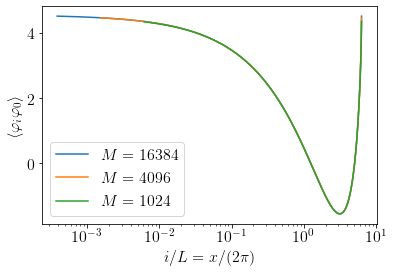

In [82]:
alpha = 1.6
for M in 2** np.array([14, 12, 10]):
    xs =np.arange(1,M) / M * np.pi *2
  

    Gk = get_Gk(M, alpha)
    Gk[0] = 0
    Gr = np.fft.fft(Gk).real
    plt.loglog(xs, Gr[1:],  label=r"$M = %d$" % M)
    print("M = %d" % M)
plt.legend()
plt.ylabel(r"$\left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i/L = x / (2\pi)$ ")
xs = np.linspace(.5e-3, 1, 5)
#a = alpha / 2
plt.yscale("linear")
#plt.plot(xs, xs ** (alpha - 1) * C, c = "k", ls = "--")

In [ ]:
alpha = 1.6
for M in 2** np.array([14, 12, 10]):
    xs =np.arange(1,M) / M * np.pi *2
  

    Gk = get_Gk(M, alpha)
    Gk[0] = 0
    Gr = np.fft.fft(Gk).real
    plt.loglog(xs, Gr[0] - Gr[1:],  label=r"$M = %d$" % M)
    print("M = %d" % M)
plt.legend()
plt.ylabel(r"$\left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i/L = x / (2\pi)$ ")
xs = np.linspace(.5e-3, 1, 5)
a = alpha / 2
C = -np.pi**(1/2) * 2 ** (1 - 2 * a)  * gamma(1/2-a) / gamma(a) 
plt.plot(xs, xs ** (alpha - 1) * C, c = "k", ls = "--")

## Lattice regularization: the lattice (UV) point of view

Now, we set lattice spacing to be $1$, so $x = j$, then the physical momenta $q = 2\pi k / M \in [0, 2\pi]$ are defined inside a Broullin zone. We still want the GFF to be governed by an action 
$$ S = \int_{\text{BZ}} G_q^{-1} |\hat{\phi}_q|^2  d q \,,\, G_q^{-1} \approx |q|^{\alpha}  $$
for small $q$. Note that 
$$ \hat{\phi}_q = \sum_j e^{\mathrm{i} q j} \phi_j $$

- Repeat the logic above to figure out how to generate the GFF in this setting. 

Observe the fields generated below, paying particular attention to the value of the field.

In [ ]:
#preparation
def get_Gk_UV(M, alpha):
    """
    prepare the propagator.
    parameters: M (system size) and alpha (long range exponent)
    """
    Gk = np.sin(np.arange(M)/M*np.pi) * 2
    Gk[0] = 1
    Gk = Gk ** -alpha
    Gk[0] = 0
    return Gk

In [ ]:
M = 2 ** 12
fig,ax= plt.subplots(3,1,figsize = (8, 8),sharex="all")
xs = np.arange(M) 
for j,alpha in enumerate([.5,1.,2.]):
    Gk = get_Gk_UV(M, alpha)
    phi = np.fft.ifft(( rnd.randn(M) +  rnd.randn(M) * 1.j) * (Gk ** .5)).real * (M ** .5) * ((np.pi *2) ** .5)
    plt.sca(ax[j])
    plt.plot(xs,phi)
    plt.title(r"$\alpha=%g$" % alpha)
    plt.ylabel(r"$\varphi_i$")
plt.xlabel("$x = i$")

We again look at the propagator in space domain, with $\alpha < 1$ and $\alpha > 1$.

Argue that 
- for $\alpha < 1$, $\left< \varphi_i^2 \right>$ is finite in the thermodynamic limit. 
- For $\alpha > 1$, $\left< \varphi_i^2 \right> \sim M^{\alpha - 1}$. The field has wider fluctuations in larger system sizes. In the context of statistical mechanics (surface growth, etc), we say the interface is "rough", with a Hurst roughness exponent 
#### $$ H = \frac{\alpha - 1}2$$ 
$H$ is essentially the opposite of the scaling dimension!

- What is the relation between the two lattice regularizations? Argue that the relation is exactly the same as between a microscopic operator and its scaling limit, i.e.,
#### $$ \varphi^{\text{(UV)}}(x) = b^{-\Delta} \varphi^{\text{(IR)}}(x / b) \,,\, \Delta = \frac{1 - \alpha}{2} $$
where $b = M / (2\pi)$.

In [ ]:
alpha = .5
for M in 2** np.array([16,14,12 ]):
    xs =np.arange(1,M) 
    Gk = get_Gk_UV(M, alpha)
    Gr = np.fft.ifft(Gk).real * np.pi * 2
    plt.loglog(xs, Gr[1:],  label=r"$M = %d$" % M)
plt.legend()
plt.ylabel(r"$\left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i$")
xs = np.linspace(1, 1000, 5)
a = alpha / 2 
C = np.pi**(1/2) * 2 ** (1 - 2 * a)  * gamma(1/2-a) / gamma(a) 
plt.plot(xs , xs ** (alpha - 1) * C , c = "k", ls="--")

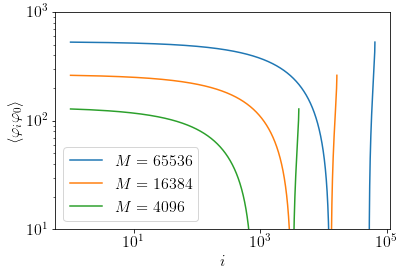

In [87]:
alpha = 1.5
for M in 2** np.array([16,14,12 ]):
    xs =np.arange(1,M) 
    Gk = get_Gk_UV(M, alpha)
    Gr = np.fft.ifft(Gk).real * np.pi * 2
    plt.loglog(xs,  Gr[1:],  label=r"$M = %d$" % M)
plt.legend()
plt.ylim(10, 1e3)
plt.ylabel(r"$\left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i$")
xs = np.linspace(1, 10000, 5)


In [ ]:
alpha = 1.5
for M in 2** np.array([16,14,12 ]):
    xs =np.arange(1,M) 
    Gk = get_Gk_UV(M, alpha)
    Gr = np.fft.ifft(Gk).real * np.pi * 2
    plt.loglog(xs, Gr[0] - Gr[1:],  label=r"$M = %d$" % M)
plt.legend()
plt.ylabel(r"$\left< \varphi_0 \varphi_0 \right> - \left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i$")
xs = np.linspace(1, 10000, 5)
a = alpha / 2
#C = gamma(1-alpha) * np.sin(np.pi / 2 * alpha) * 2 #np.pi**(1/2) * 2 ** (1/2 - 2 * a)  * gamma(1/2-a) / gamma(a) 
C = -np.pi**(1/2) * 2 ** (1 - 2 * a)  * gamma(1/2-a) / gamma(a) 
plt.plot(xs , xs ** (alpha - 1) * C , c = "k", ls="--")

## The log case

When $\alpha = 1$, the scaling dimension is $0$, and the roughness exponent is $0$. The amplitude of the field looks the same from UV and IR point of view. 

In fact, the propagator is logarithmically divergent: the Fourier transform of $1/|k|$ in 1D, and $1/|k|^d$ in d dimension in general, are all logarithmic in $x$. One can see that by taking a limit of the power law Fourier transform formula (the prefactor $C(a)$ has a pole which leads to log correction to scaling.)

In particular, $\left< \varphi_i^2 \right> \sim \ln M$. This divergence is neither a UV nor an IR divergence: it comes from all the scales. So there is no good way to get rid of it (in contrast to $\alpha < 1$ and $\alpha > 1$); one should rather embrace the interesting physics it brings.

We shall study in the detail the log-correlated fields in 2D instead, because the 2D Gaussian free field is naturally log-correlated. It is more important (and nicer looking) than its 1D cousin (aka $1/f$ noise). 

In [ ]:
alpha = 1
for M in 2** np.array([16,14,12 ]):
    xs =np.arange(1,M) / M
    Gk = get_Gk_UV(M, alpha)
    Gr = np.fft.ifft(Gk).real
    plt.loglog(xs, Gr[1:],  label=r"$M = %d$" % M)
plt.legend()
plt.yscale("linear")
plt.ylabel(r"$\left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i / M$")
xs = np.linspace(1e-4, 1, 5)
plt.plot(xs , -(np.log(xs) * 2) / np.pi / 2, c = "k", ls="--")

In [ ]:
alpha = 1.
for M in 2** np.array([16,14,12 ]):
    xs =np.arange(1,M) 
    Gk = get_Gk_UV(M, alpha)
    Gr = np.fft.ifft(Gk).real
    plt.loglog(xs, Gr[0] - Gr[1:],  label=r"$M = %d$" % M)
plt.legend()
plt.ylabel(r"$\left< \varphi_0 \varphi_0 \right> - \left< \varphi_i \varphi_0 \right>$")
plt.xlabel("$i$")
plt.yscale("linear")
xs = np.linspace(1, 10000, 5)
plt.plot(xs , (np.log(xs) * 2) / np.pi / 2, c = "k", ls="--")